In [1]:
%matplotlib inline
import pylab as pl
import numpy as np
# If you use a light background, change (or "comment out") the next line:
pl.style.use('dark_background')
pl.rcParams['figure.figsize'] = (10,8)

# Space-based observation planning

We have been planning observations as ground-based observers, since that's what we are!

What about space-based observations?

Space-based observation planning depends on where your spacecraft is.

There are a few important orbits, with an example next to each:

1. Low Earth Orbit (LEO) - Hubble
2. Geosynchronous / high-earth orbit - Chandra
3. Lagrange Point (L2) - Herschel
4. Heliocentric - Kepler

For these orbits, the day/night cycle is usually not so important.  [Hubble orbits the Earth once every 90 minutes](https://esahubble.org/videos/hubblecast78b/), and its "night" is caused by the Earth eclipsing the sun.

With satellites like Hubble, they can observe whatever is visible from the night side of Earth, pretty much.

Sometimes there are additional restrictions: satellites have to make sure their solar panels point toward the sun during their "day" so their batteries stay charged.

For ground-based observing, the "best" time and place to observe is exactly away from the sun, but for many satellites, the solar panel restrictions mean they can never point directly away from the sun.

To determine what parts of the sky can, and can't, be looked at at any given time, we can plot the position of the sun over the course of a year

In [2]:
# first, set up an array of times covering a whole year with 365 days * 24 hours points
from astropy import time
times = time.Time(np.linspace(2021.0, 2021.999, 365*24), format='decimalyear')
times

<Time object: scale='utc' format='decimalyear' value=[2021.         2021.00011405 2021.00022811 ... 2021.99877189 2021.99888595
 2021.999     ]>

In [3]:
# we will make up an observer that is 600 kilometers above Gainesville
# (a LEO satellite could go overhead like this)
from astropy import coordinates, units as u
observer = coordinates.EarthLocation.from_geodetic(-82.3*u.deg, 29.6*u.deg, 600*u.km)

In [4]:
# then, let's get the sun's coordinates
sun_crds = coordinates.get_body(body='Sun', time=times)

Text(0, 0.5, 'Declination (degrees)')

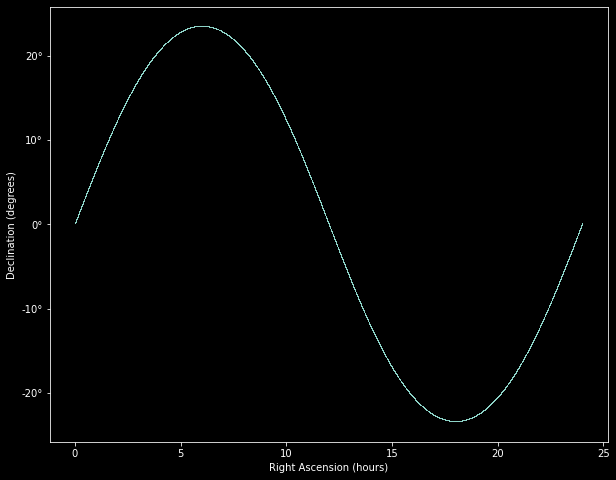

In [5]:
# now let's plot them:
from astropy.visualization import quantity_support
quantity_support() # this makes matplotlib play nice with units
# we want RA in hours, so we have to convert to hours
pl.plot(sun_crds.ra.to(u.hourangle), sun_crds.dec, ',')
pl.xlabel("Right Ascension (hours)")
pl.ylabel("Declination (degrees)")

The plot above should look familiar: it is exactly the plot of the Sun's position on the sky from the coordinates and time lecture.

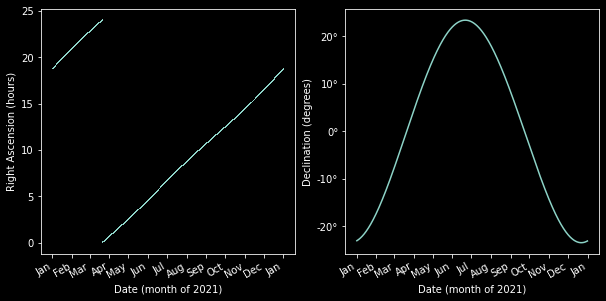

In [6]:
# this cell shows you several tricks for plotting nicely-formatted dates
from astropy.visualization import time_support
import matplotlib.dates as mdates
months = mdates.MonthLocator() # tells the plotter to put a tickmark at every month

# "time_support" tells astropy how to talk to matplotlib
with time_support(format='plot_date'):
    fig = pl.figure(figsize=(10,5))
    ax1 = pl.subplot(1,2,1)
    ax1.plot(times, sun_crds.ra.to(u.hourangle), ',')
    ax1.set_ylabel("Right Ascension (hours)")
    ax1.set_xlabel("Date (month of 2021)")
    ax2 = pl.subplot(1,2,2)
    ax2.plot(times, sun_crds.dec, '-')
    ax2.set_ylabel("Declination (degrees)")
    ax2.set_xlabel("Date (month of 2021)")

# since all the dates are from 1 year, we want to show month on the X-axis
# "%b" is the string format for shorthand month names
# https://docs.python.org/3/library/datetime.html#datetime.datetime.strftime
ax1.xaxis.set_major_locator(months)
ax1.xaxis.set_major_formatter(mdates.DateFormatter("%b"))
ax2.xaxis.set_major_locator(months)
ax2.xaxis.set_major_formatter(mdates.DateFormatter("%b"))

fig.autofmt_xdate()

The plot above shows the RA change - which broadly tells you which sources are "Day" and "Night" sources - and the Declination change, which controls the seasons.

# Making "observability" plots

What can we do with this information?

We can look at what times of year we can observe different parts of the Galaxy, for example.

This next section will use a couple sophisticated tools for plotting and is meant to show an advanced application of the tools you're learning.  You won't need to reproduce all of this, but you might want to!

In [7]:
# Download an all-sky image in X-rays from the ROSAT X-ray telescope
from astropy.io import fits
from astropy.utils.data import get_pkg_data_filename
from astropy.wcs import WCS

filename = get_pkg_data_filename('allsky/allsky_rosat.fits')
hdu = fits.open(filename)[0]
wcs = WCS(hdu.header)

In [8]:
# pick a time: January 1
plot_time = time.Time(2021.0, format='decimalyear')
plot_time.iso

'2021-01-01 00:00:00.000'

In [9]:
# get the sun's coordinate now
sun = coordinates.get_body(body='Sun', time=plot_time)
# use a trick to convert the sun's coordinate now to Galactic
sun = coordinates.SkyCoord(sun.spherical, frame='fk5').galactic

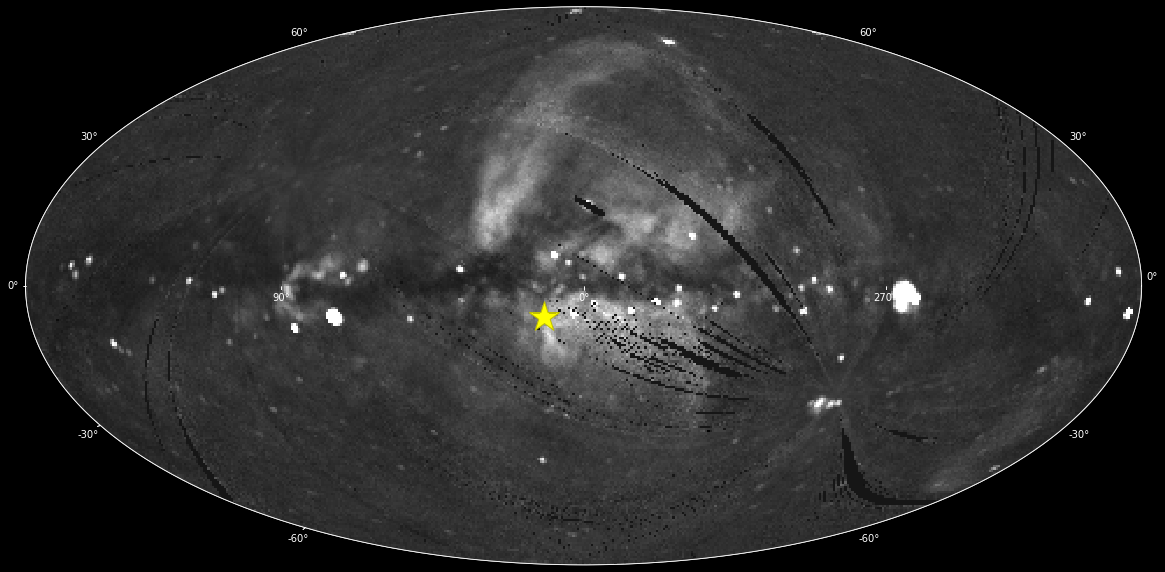

In [10]:
from astropy.visualization.wcsaxes.frame import EllipticalFrame

fig = pl.figure(1, figsize=(20,15))
fig.clf()
ax = pl.subplot(projection=wcs, frame_class=EllipticalFrame)
transform = ax.get_transform('galactic')
im = ax.imshow(hdu.data, origin='lower', cmap='gray', interpolation='none', vmax=1000)
sc = ax.scatter(sun.l, sun.b, marker='*', c='yellow', transform=transform, edgecolor='y', s=1000)

The plot above shows our all-sky plot centered on the Galactic Center (showing the X-ray bubbles blowing out of the Galactic Center!) with the Sun overplotted as a star.

## QUESTION

Is January a good time to observe the Galactic Center? Why or why not?

-your answer here-

## Sun Avoidance Zone

In the next plot, we use some more tricks to countour out the part of the sky that is >90 degrees from the Sun.  The overlaid contour shows the part we can observe, while the un-contoured region near the Sun is only up during the day.

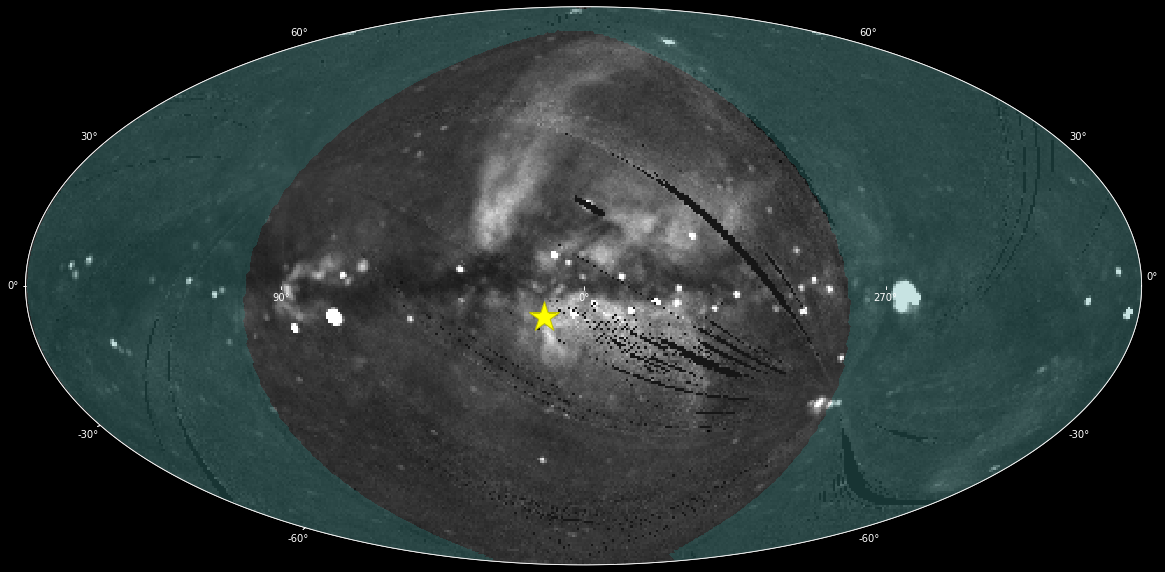

In [11]:
def sun_avoidance_plot(plot_time):
    fig = pl.figure(1, figsize=(20,15))
    fig.clf()
    ax = pl.subplot(projection=wcs, frame_class=EllipticalFrame)
    transform = ax.get_transform('galactic')
    im = ax.imshow(hdu.data, origin='lower', cmap='gray', interpolation='none', vmax=1000)
    sc = ax.scatter(sun.l, sun.b, marker='*', c='yellow', transform=transform, edgecolor='y', s=1000)

    axlims = pl.axis()
    ellgrid,beegrid = np.mgrid[-180:180,-90:90]
    coordgrid = coordinates.SkyCoord(ellgrid*u.deg, beegrid*u.deg, frame='galactic')
    sep = coordgrid.separation(sun)
    con = ax.contourf(ellgrid, beegrid, (sep>90*u.deg), levels=[0.5, 1.5], transform=transform, alpha=0.25)
    ax.axis(axlims)
    return ax
    
ax = sun_avoidance_plot(plot_time)

# EXERCISE

Select different plot times around the year and make observability plots using the `sun_avoidance_plot` function.

### QUESTION:

What month(s) are best to observe the Galactic Center?

-your answer here-

Are there parts of the sky that are always in the sun avoidance zone?  Never?  Explain

-your answer here-

# The Pole Star

Using the tools you learned in the Observation Planning notebook, overplot Polaris on the plot above.

To do this, you need to create a Polaris coordinate object (which you learned how to do), then convert it to Galactic:

In [12]:
polaris = coordinates.SkyCoord.from_name('Polaris')

In [13]:
polaris_galactic = polaris.galactic

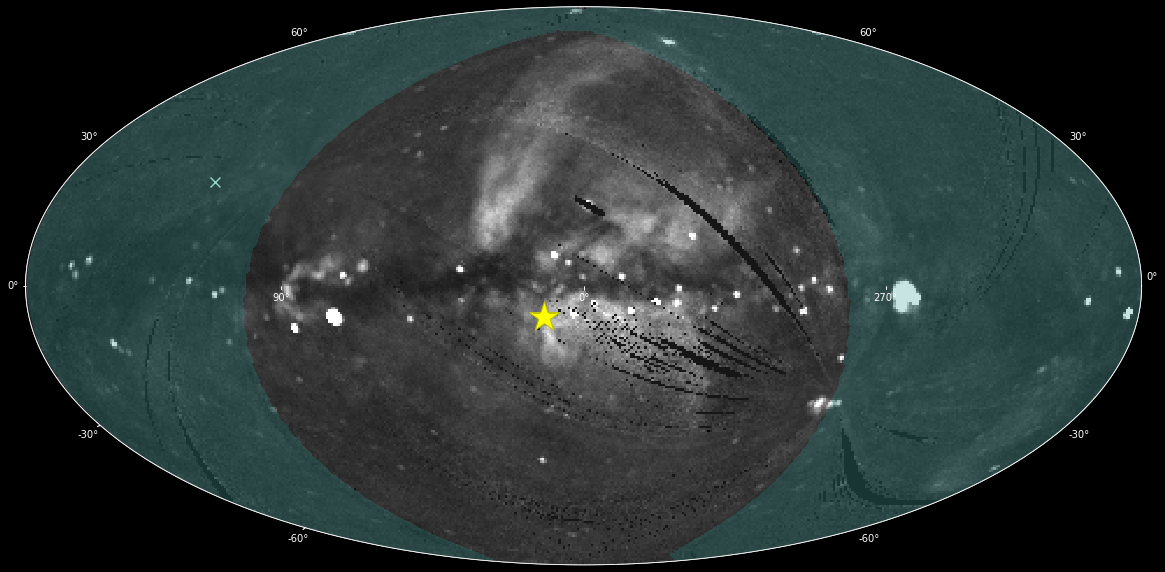

In [14]:
ax = sun_avoidance_plot(plot_time)
ax.scatter(polaris_galactic.l, polaris_galactic.b, s=100, marker='x', transform=ax.get_transform('galactic'))

# Exercise

Do the same thing you did for Polaris, but now with the Large Magellanic Cloud (usually abbreviated LMC).

(you might want to use a larger plot symbol `s`, so maybe `s=1000` instead of 100)

In [15]:
LMC = coordinates.SkyCoord.from_name('Large Magellanic Cloud')

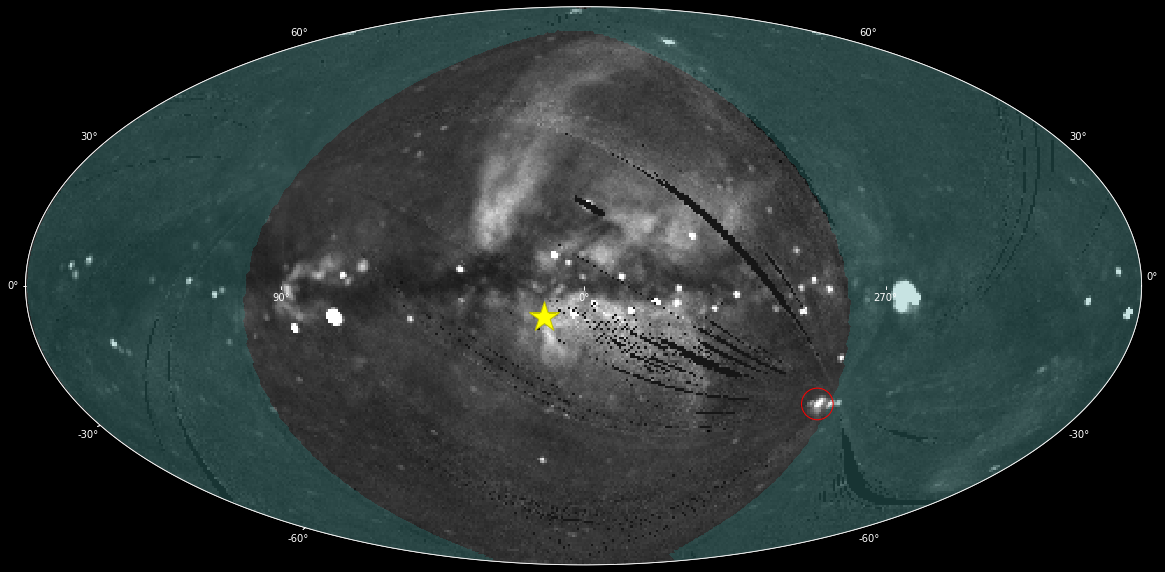

In [16]:
ax = sun_avoidance_plot(plot_time)
ax.scatter(LMC.galactic.l, LMC.galactic.b, s=1000, marker='o', edgecolor='red', facecolor='none', transform=ax.get_transform('galactic'))

QUESTION:

What do the LMC and Polaris have in common?

-your answer here-

QUESTION:

Polaris is always observable, every night of the year, from Gainesville, but it is sometimes in the sun avoidance zone.  Why can we observe it year round?  Can a spacecraft observe it year round?

-your answer here-